# Supplementary Figure 5

In [1]:
import os.path as op
import pandas as pd
import numpy as np
from sklearn import linear_model
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import plotutils

In [2]:
df_dir = op.join('..', 'data', 'dataframes')

In [3]:
subjects, rois, tasks = plotutils.default_data()

In [4]:
plotutils.set_plot_style()

### Load dataframes

In [5]:
params = pd.read_csv(op.join(df_dir, 'group_ang_fits.csv'))
params_boot = pd.read_csv(op.join(df_dir, 'group_ang_fits_boots.csv'))

pred_data = pd.read_csv(op.join(df_dir, 'pRFpred_group_ang_data.csv'))
params_pred = pd.read_csv(op.join(df_dir, 'pRFpred_group_ang_fits.csv'))
params_pred_boots = pd.read_csv(op.join(df_dir, 'pRFpred_group_ang_fits_boots.csv'))

In [6]:
pal = ['#d95f02', '#e6a778']
pal_dict = dict(zip(tasks, pal))

pred_mods = ['pred_onegaussian', 'pred_css', 'pred_dog']
pal_pred = dict(zip(pred_mods, ['#737373', '#e7298a', '#1b9e77']))

### Supplementary Figure 5a

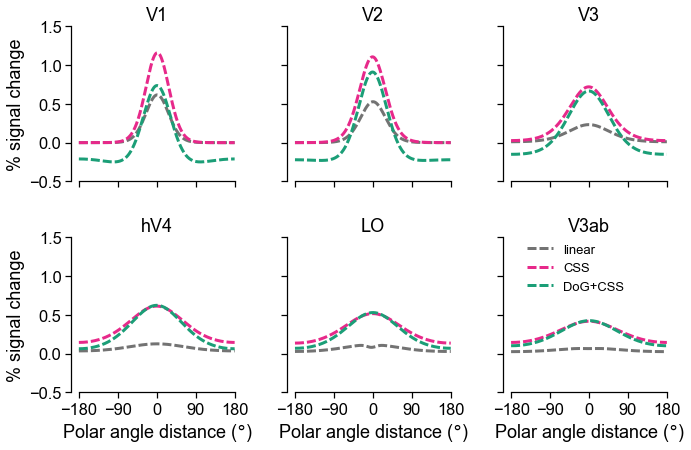

In [7]:
# Set up axes
g = sns.FacetGrid(col='roi', col_order=rois, col_wrap=3, height=3.3, aspect=1, data=pred_data)

# Plot von mises fits to DoG model predictions
theta = np.linspace(-np.pi, np.pi, 361) 

for r, m in itertools.product(g.col_names, pred_mods):
    ax_i = rois.index(r)
    p = params_pred.query("roi==@r & prf_model==@m").iloc[0][['loc', 'kappa1', 'scale1', 'kappa2', 'scale2']]
    yhat_pred = plotutils.diff_vonmises(theta, *p)
    g.axes.flatten()[ax_i].plot(np.rad2deg(theta), yhat_pred, label=m, 
                                lw=3, ls="--", dashes=(3,1), c=pal_pred[m])

g.set(xticks=np.arange(-180, 225, 90), ylim=[-.5, 1.5], yticks=[-.5, 0, .5, 1, 1.5])
g.set_xlabels('Polar angle distance ($\\degree$)')
g.set_ylabels('% signal change')
g.set_titles(col_template="{col_name}")

handles, labels = g.axes[5].get_legend_handles_labels()
g.axes[5].legend(handles, ['linear', 'CSS', 'DoG+CSS'], loc='center left', 
                 frameon=False, bbox_to_anchor=(0.07, 0.8), fontsize=13)

sns.despine(trim=True)
plt.gcf().tight_layout(h_pad=1.5, w_pad=1.5)

### Supplementary Figure 5b

In [8]:
params_scatter = []
for pred in pred_mods:
    p = params.merge(params_pred.query("prf_model==@pred"), on=['hemi', 'roi'], suffixes=('', '_pred'))
    params_scatter.append(p)
params_scatter = pd.concat(params_scatter).reset_index(drop=True)

In [9]:
params_pred_boots = params_pred_boots[params_pred_boots['roi'].isin(rois)]
params_pred_boots = params_pred_boots.replace([np.inf, -np.inf], np.nan).dropna()

In [10]:
boot_scatter = []
for pred in pred_mods:
    p = params_boot.merge(params_pred_boots.query("prf_model==@pred"), 
                          on=['hemi', 'roi', 'n_boot'], 
                          suffixes=('', '_pred'))
    boot_scatter.append(p)
boot_scatter = pd.concat(boot_scatter).reset_index(drop=True)

*Amplitude*

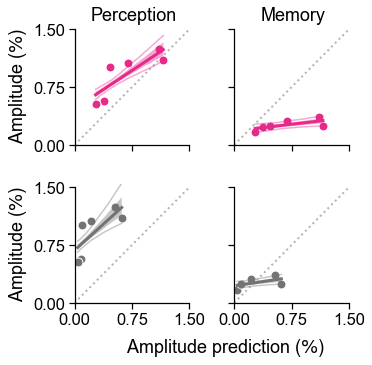

In [11]:
g = sns.lmplot(x='amp_pred', y='amp', col='task', col_order=tasks,
               hue='prf_model', palette=pal_pred, 
               row='prf_model', row_order=['pred_css', 'pred_onegaussian'],
               scatter_kws={"s":80, 'lw':1, 'edgecolors':"1", 'alpha':1},
               fit_reg=True, ci=0, line_kws={'lw':3}, 
               legend=False, height=2.5, aspect=1.1, 
               data=params_scatter)

betas_95 = {'pred_css':{}, 'pred_onegaussian':{}}

fd = [d for (i, d) in g.facet_data() if not d.empty]
for i, d in enumerate(fd):
    ax = g.axes.flatten()[i]
    xmin = ax.get_lines()[0].get_data()[0].min()
    xmax = ax.get_lines()[0].get_data()[0].max()
    x_grid = np.linspace(xmin, xmax, 100).reshape(-1, 1)
    
    t,m = d[['task', 'prf_model']].iloc[0]
    bs = boot_scatter.query("task==@t & prf_model==@m")
    b_95, err_68, err_95 = plotutils.pred_scatter_bootstrap(bs, x_grid, 'amp')
    betas_95[m][t] = b_95
    
    ax.fill_between(x_grid.squeeze(), *err_68, facecolor=pal_pred[m], alpha=.4)
    ax.plot(x_grid.squeeze(), err_95[0], color=pal_pred[m], lw=1.5, alpha=.4)
    ax.plot(x_grid.squeeze(), err_95[1], color=pal_pred[m], lw=1.5, alpha=.4)

g.set(ylim=[0, 1.54], xlim=[0, 1.54], yticks=[0, .75, 1.5], xticks=[0, .75, 1.5])
g.set_xlabels('')
g.set_ylabels('Amplitude ($\%$)')
g.set_titles(template="{col_name}")
g.axes[1][0].set_title('')
g.axes[1][1].set_title('')

for ax in g.axes.flatten():
    ax.set_title(ax.get_title().capitalize())
    ax.plot([0, 1.5], [0, 1.5], markersize=0, c=".7", linewidth=2, ls=":", zorder=0)

plt.gcf().text(.6, 0, 'Amplitude prediction ($\%$)', va='center', ha='center')

sns.despine(trim=True)
plt.gcf().tight_layout(w_pad=.75, h_pad=1.5)

In [12]:
for model, task in itertools.product(['pred_css', 'pred_onegaussian'], tasks):
    print("{}, {}".format(model, task))
    pm = params_scatter.query("prf_model==@model & task==@task")
    x = pm['amp_pred'].values.reshape(-1, 1)
    y = pm['amp'].values.reshape(-1, 1)
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    print("beta = %.3f, ci=%s" %(regr.coef_, betas_95[model][task]))

pred_css, perception
beta = 0.660, ci=[0.45285372 0.91369477]
pred_css, memory
beta = 0.117, ci=[0.02756568 0.18899173]
pred_onegaussian, perception
beta = 0.900, ci=[0.50650824 1.43432701]
pred_onegaussian, memory
beta = 0.147, ci=[0.01007923 0.24641007]


*FWHM*

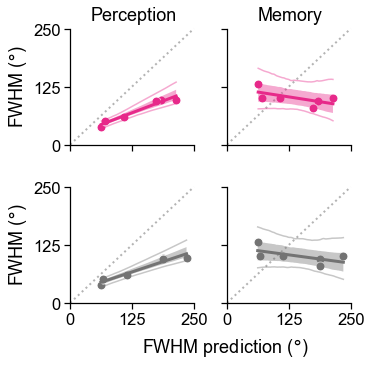

In [13]:
g = sns.lmplot(x='fwhm_deg_pred', y='fwhm_deg', col='task', col_order=tasks,
               hue='prf_model', palette=pal_pred, 
               row='prf_model', row_order=['pred_css', 'pred_onegaussian'],
               scatter_kws={"s":80, 'lw':1, 'edgecolors':"1", 'alpha':1},
               fit_reg=True, ci=0, line_kws={'lw':3}, 
               legend=False, height=2.5, aspect=1.1, 
               data=params_scatter)

betas_95 = {'pred_css':{}, 'pred_onegaussian':{}}

fd = [d for (i, d) in g.facet_data() if not d.empty]
for i, d in enumerate(fd):
    ax = g.axes.flatten()[i]
    xmin = ax.get_lines()[0].get_data()[0].min()
    xmax = ax.get_lines()[0].get_data()[0].max()
    x_grid = np.linspace(xmin, xmax, 100).reshape(-1, 1)
    
    t,m = d[['task', 'prf_model']].iloc[0]
    bs = boot_scatter.query("task==@t & prf_model==@m")
    b_95, err_68, err_95 = plotutils.pred_scatter_bootstrap(bs, x_grid, 'fwhm_deg')
    betas_95[m][t] = b_95
    
    ax.fill_between(x_grid.squeeze(), *err_68, facecolor=pal_pred[m], alpha=.4)
    ax.plot(x_grid.squeeze(), err_95[0], color=pal_pred[m], lw=1.5, alpha=.4)
    ax.plot(x_grid.squeeze(), err_95[1], color=pal_pred[m], lw=1.5, alpha=.4)

g.set(ylim=[0, 255], xlim=[0, 255], yticks=[0, 125, 250], xticks=[0, 125, 250])
g.set_xlabels('')
g.set_ylabels('FWHM ($\\degree$)')
g.set_titles(template="{col_name}")
g.axes[1][0].set_title('')
g.axes[1][1].set_title('')

for ax in g.axes.flatten():
    ax.set_title(ax.get_title().capitalize())
    ax.plot([0, 250], [0, 250], markersize=0, c=".7", linewidth=2, ls=":", zorder=0)

plt.gcf().text(.6, 0, 'FWHM prediction ($\\degree$)', va='center', ha='center')

sns.despine(trim=True)
plt.gcf().tight_layout(w_pad=.75, h_pad=1.5)

In [14]:
for model, task in itertools.product(['pred_css', 'pred_onegaussian'], tasks):
    print("{}, {}".format(model, task))
    pm = params_scatter.query("prf_model==@model & task==@task")
    x = pm['fwhm_deg_pred'].values.reshape(-1, 1)
    y = pm['fwhm_deg'].values.reshape(-1, 1)
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    print("beta = %.3f, ci=%s" %(regr.coef_, betas_95[model][task]))

pred_css, perception
beta = 0.406, ci=[0.29745187 0.59894318]
pred_css, memory
beta = -0.166, ci=[-0.53692286  0.22372331]
pred_onegaussian, perception
beta = 0.355, ci=[0.27366863 0.51047711]
pred_onegaussian, memory
beta = -0.144, ci=[-0.46532599  0.20378763]
